In [1]:
#Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb

In [2]:
#Importing the data

df = pd.read_csv('/kaggle/input/health-expenditure-australia-1997-2012/healthexpenditureaustralia.csv')

In [3]:
#Data Analysis
df

,financial_year,state,area_of_expenditure,broad_source_of_funding,detailed_source_of_funding,real_expenditure_millions
0,1997-98,NSW,Administration,Government,Australian Government,315
1,1997-98,NSW,Administration,Government,State and local,120
2,1997-98,NSW,Administration,Non-government,Private health insurance funds,314
3,1997-98,NSW,Aids and appliances,Government,Australian Government,65
4,1997-98,NSW,Aids and appliances,Non-government,Individuals,168
...,...,...,...,...,...,...
6773,2011-12,NT,Public hospitals,Non-government,Private health insurance funds,1
6774,2011-12,NT,Research,Government,Australian Government,81
6775,2011-12,NT,Research,Government,State and local,35
6776,2011-12,NT,Research,Non-government,Individuals,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6778 entries, 0 to 6777
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   financial_year              6778 non-null   object
 1   state                       6778 non-null   object
 2   area_of_expenditure         6778 non-null   object
 3   broad_source_of_funding     6778 non-null   object
 4   detailed_source_of_funding  6778 non-null   object
 5   real_expenditure_millions   6778 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 317.8+ KB


In [5]:
df['financial_year'].unique()


array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
       '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
       '2009-10', '2010-11', '2011-12'], dtype=object)

In [6]:
df['state'].unique()

array(['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT'], dtype=object)

In [7]:
df['area_of_expenditure'].unique()

array(['Administration', 'Aids and appliances', 'All other medications',
       'Benefit-paid pharmaceuticals', 'Capital expenditure',
       'Community health', 'Dental services',
       'Medical expense tax rebate', 'Medical services',
       'Other health practitioners', 'Patient transport services',
       'Private hospitals', 'Public health', 'Public hospitals',
       'Research'], dtype=object)

In [8]:
df['broad_source_of_funding'].unique()

array(['Government', 'Non-government'], dtype=object)

In [9]:
df['detailed_source_of_funding'].unique()

array(['Australian Government', 'State and local',
       'Private health insurance funds', 'Individuals',
       'Other non-government'], dtype=object)

#### Observations
  * All of the columns except (expenditure) contain categorical data. <br>
  * The broad and detailed source of funding are linked:
    Govt sources are (Australian and State) & Non-Govt sources are (Private health insurance funds,         Individuals, Other non-government). </b>



In [10]:
#Data Preprocessing

#Creating new funding column
df['funding'] = None  #all values NaN in new column
for i in range(df.shape[0]):
    if df['broad_source_of_funding'][i]=='Government': 
        if df['detailed_source_of_funding'][i]=='Australian Government':
            df.iloc[i,df.columns.get_loc('funding')]='Central Govt'  #Updating value of cell
        else:
            df.iloc[i,df.columns.get_loc('funding')]='State Govt'
    else: 
        if df['detailed_source_of_funding'][i]=='Private health insurance funds':
            df.iloc[i,df.columns.get_loc('funding')]='Insurance'
        elif df['detailed_source_of_funding'][i]=='Individuals':
            df.iloc[i,df.columns.get_loc('funding')]= 'Individuals'
        elif df['detailed_source_of_funding'][i]=='Other non-government':
            df.iloc[i,df.columns.get_loc('funding')] = 'Other'

In [11]:
df.head()


,financial_year,state,area_of_expenditure,broad_source_of_funding,detailed_source_of_funding,real_expenditure_millions,funding
0,1997-98,NSW,Administration,Government,Australian Government,315,Central Govt
1,1997-98,NSW,Administration,Government,State and local,120,State Govt
2,1997-98,NSW,Administration,Non-government,Private health insurance funds,314,Insurance
3,1997-98,NSW,Aids and appliances,Government,Australian Government,65,Central Govt
4,1997-98,NSW,Aids and appliances,Non-government,Individuals,168,Individuals


In [12]:
#Removing the previous funding columns
df = df.drop(columns=['broad_source_of_funding','detailed_source_of_funding'])

In [13]:
df

,financial_year,state,area_of_expenditure,real_expenditure_millions,funding
0,1997-98,NSW,Administration,315,Central Govt
1,1997-98,NSW,Administration,120,State Govt
2,1997-98,NSW,Administration,314,Insurance
3,1997-98,NSW,Aids and appliances,65,Central Govt
4,1997-98,NSW,Aids and appliances,168,Individuals
...,...,...,...,...,...
6773,2011-12,NT,Public hospitals,1,Insurance
6774,2011-12,NT,Research,81,Central Govt
6775,2011-12,NT,Research,35,State Govt
6776,2011-12,NT,Research,0,Individuals


In [14]:
#Creating input dataframe using one hot enconding
ohe_state = pd.get_dummies(df.state).astype(int)
ohe_year = pd.get_dummies(df.financial_year).astype(int)
ohe_expenditure = pd.get_dummies(df.area_of_expenditure).astype(int)
ohe_funding = pd.get_dummies(df.funding).astype(int)
X = pd.concat([ohe_year, ohe_state,ohe_expenditure,ohe_funding], axis = 1) #combining all ohe dataframes
X

,1997-98,1998-99,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,...,Patient transport services,Private hospitals,Public health,Public hospitals,Research,Central Govt,Individuals,Insurance,Other,State Govt
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [15]:
#Creating output dataframe
y = df.real_expenditure_millions
y

0       315
1       120
2       314
3        65
4       168
       ... 
6773      1
6774     81
6775     35
6776      0
6777      1
Name: real_expenditure_millions, Length: 6778, dtype: int64

In [16]:
#Concatenating the input and output numerical datasets for some graphical analysis
df_ready = pd.concat([X,y], axis = 1)

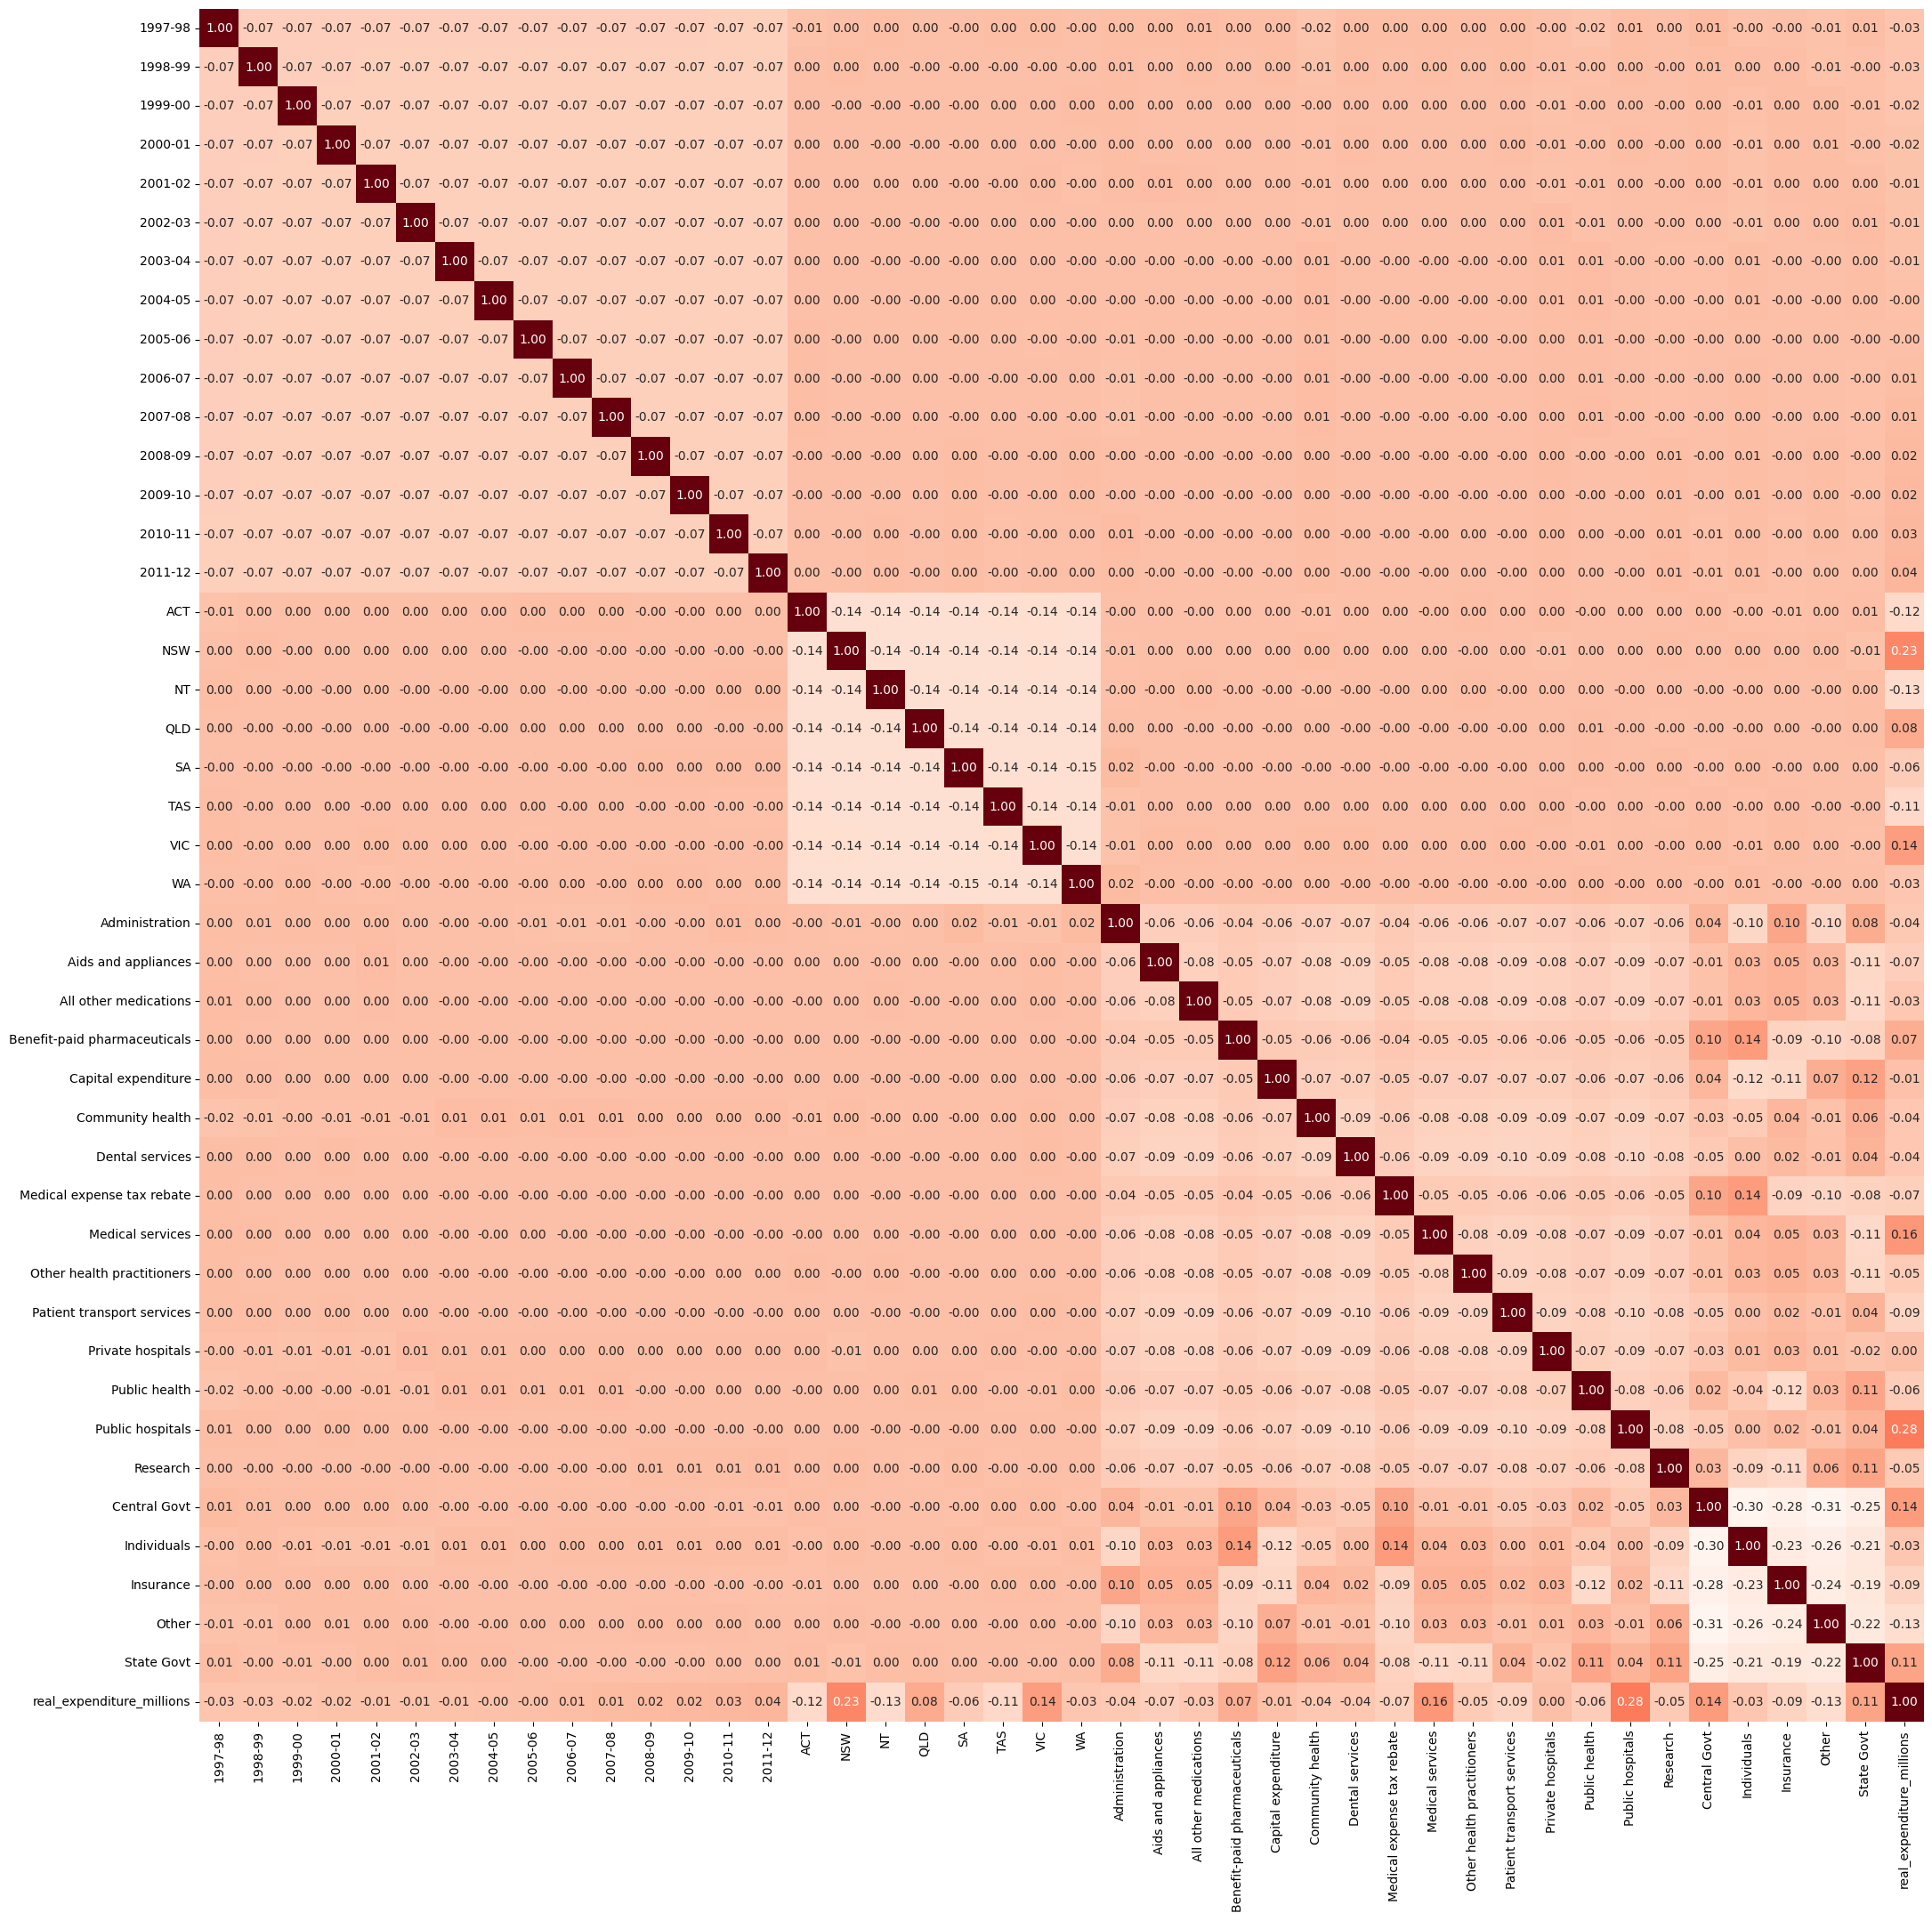

In [17]:
#Correlation Matrix
corr = df_ready.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot = True, cbar=None, cmap='Reds', fmt='0.2f');

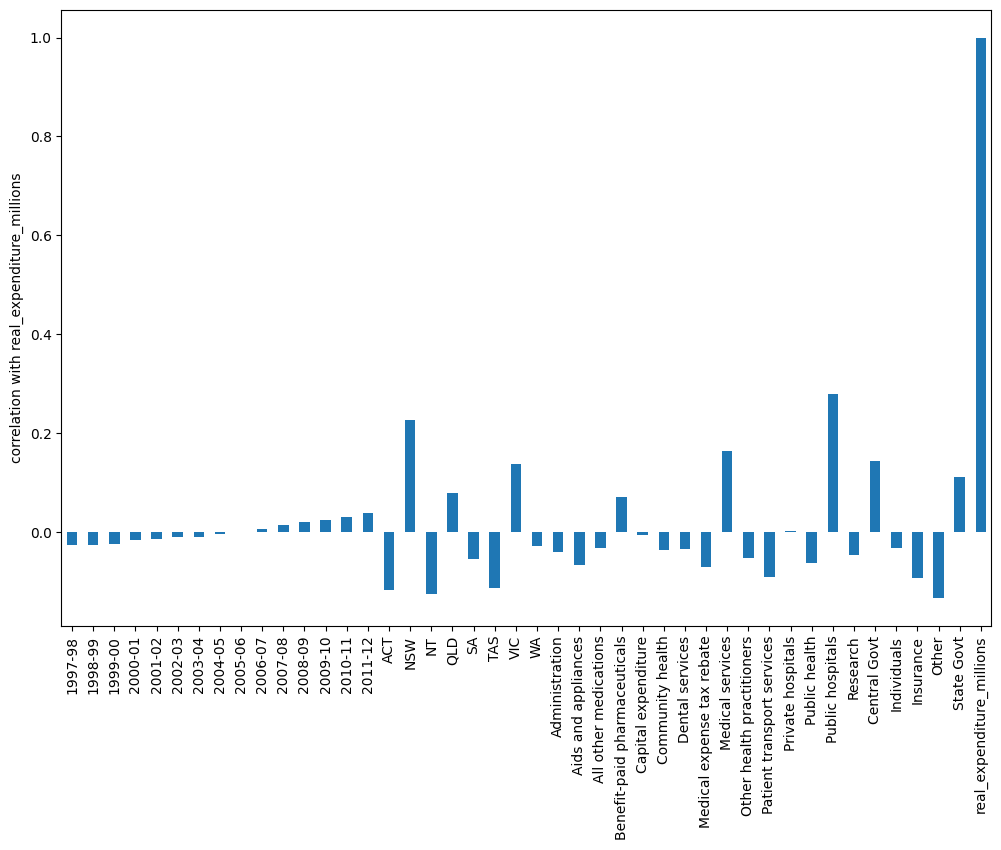

In [18]:
# Correlation of all variables with respect to target variable
fig, ax = plt.subplots(1,1, figsize =(12,8))
corrt = df_ready.corrwith(df_ready['real_expenditure_millions'])
corrt.plot(kind='bar');
plt.ylabel('correlation with real_expenditure_millions');

In [19]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True, random_state =42)

In [20]:
#Model 1 : Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

In [21]:
#Testing the predictions
print(f'R2 Score: {r2_score(y_test, y_pred1)}')
print(f'Mean Absolute error: {mean_absolute_error(y_test, y_pred1)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred1, squared = False)}')

R2 Score: 0.31254291778068444
Mean Absolute error: 275.7617994100295
RMSE: 493.3657445360766


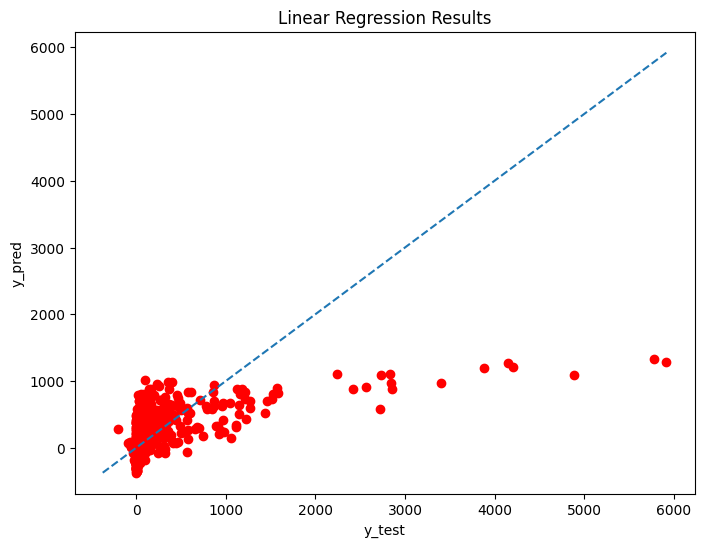

In [22]:
#Plot between test and predicted outputs
min_y_test = np.min(y_test)
min_y_pred1 = np.min(y_pred1)

max_y_test = np.max(y_test)
max_y_pred1 = np.max(y_pred1)

min_xy = min(min_y_test, min_y_pred1)
max_xy = max(max_y_test, max_y_pred1)

plt.figure(figsize=(8,6));
plt.scatter(y_test,y_pred1,color='Red')
plt.plot([min_xy,max_xy], [min_xy,max_xy], linestyle='--') # x= y line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Linear Regression Results');

**The linear regression clearly fails to account for the data as indicated by the scores and the graph hence it's a bad model. Let's build the Random forest model**

In [23]:
#Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [24]:
#Testing the predictions
print(f'R2 Score: {r2_score(y_test, y_pred2)}')
print(f'Mean Absolute error: {mean_absolute_error(y_test, y_pred2)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred2, squared = False)}')

R2 Score: 0.9382039160977131
Mean Absolute error: 51.433938053097336
RMSE: 147.9199236676608


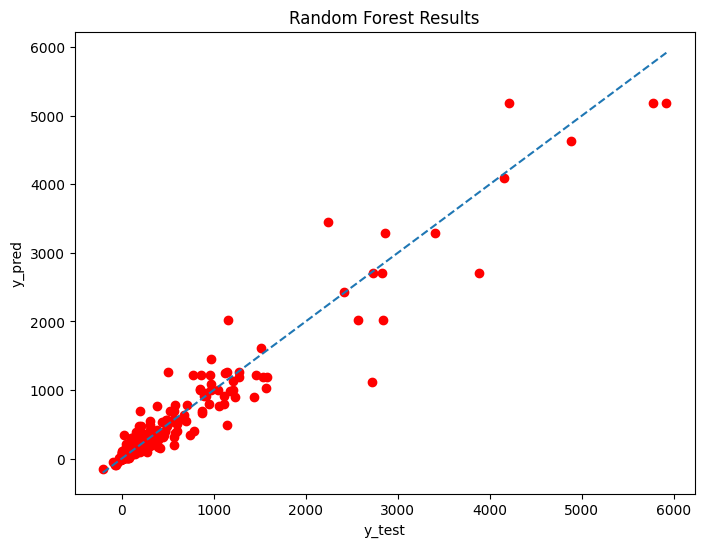

In [25]:
#Plot between test and predicted outputs
min_y_test = np.min(y_test)
min_y_pred2 = np.min(y_pred2)

max_y_test = np.max(y_test)
max_y_pred2 = np.max(y_pred2)

min_xy = min(min_y_test, min_y_pred2)
max_xy = max(max_y_test, max_y_pred2)

plt.figure(figsize=(8,6));
plt.scatter(y_test,y_pred2,color='Red')
plt.plot([min_xy,max_xy], [min_xy,max_xy], linestyle='--') # x= y line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Random Forest Results');

**The Random Forest does account for the data as indicated by the scores and the graph hence it's a much better model. For highly labelled data decision trees are generally the best. Now let's try the xGBoost model**

In [26]:
#xgboost
dtrain= xgb.DMatrix(X_train, label = y_train)
dtest= xgb.DMatrix(X_test, label = y_test)
params = {'max_depth' : 10, 'objective'  : 'reg:squarederror', 'eval_metric':'rmse', 'eta':0.1}
num_rounds = 200
model = xgb.train(params, dtrain, num_rounds)
y_pred3 = model.predict(dtest)

In [27]:
#Testing the predictions
print(f'R2 Score: {r2_score(y_test, y_pred3)}')
print(f'Mean Absolute error: {mean_absolute_error(y_test, y_pred3)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred3, squared = False)}')

R2 Score: 0.9357833720904835
Mean Absolute error: 53.087202570087946
RMSE: 150.78909865650746


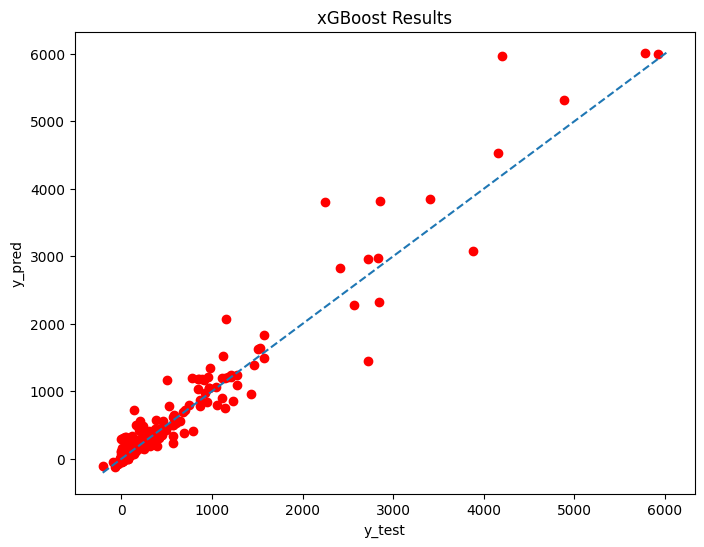

In [28]:
#Plot between test and predicted outputs
min_y_test = np.min(y_test)
min_y_pred3 = np.min(y_pred3)

max_y_test = np.max(y_test)
max_y_pred3 = np.max(y_pred3)

min_xy = min(min_y_test, min_y_pred3)
max_xy = max(max_y_test, max_y_pred3)

plt.figure(figsize=(8,6));
plt.scatter(y_test,y_pred3,color='Red')
plt.plot([min_xy,max_xy], [min_xy,max_xy], linestyle='--') # x= y line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('xGBoost Results');

**The xGBoost also does account for the data as indicated by the scores and the graph.**